In [0]:
import numpy as np
from mlxtend.data import loadlocal_mnist
import pickle 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train_x, train_y = loadlocal_mnist("/content/gdrive/My Drive/ML/Assignment3/q1_dataset/train-images-idx3-ubyte", "/content/gdrive/My Drive/ML/Assignment3/q1_dataset/train-labels-idx1-ubyte")
test_x, test_y = loadlocal_mnist("/content/gdrive/My Drive/ML/Assignment3/q1_dataset/t10k-images-idx3-ubyte", "/content/gdrive/My Drive/ML/Assignment3/q1_dataset/t10k-labels-idx1-ubyte")
train_x = preprocessing.normalize(train_x)
test_x = preprocessing.normalize(test_x)

In [0]:
class Neural_Net:
    def __init__(self, N=0, arr=[], activationF="relu", alpha=0.1):
        self.N = N
        self.arr = arr
        self.activationF = activationF
        self.alpha = alpha
        self.weight = []
        self.bias = []
        self.initialize_weights()
        self.X = [None for i in range(self.N)]
        self.labels = []
        self.weightChange = [None for i in range(self.N-1)]
        self.biasChange = [None for i in range(self.N-1)]
        # print(len(self.X),self.weight,'\n',self.bias)

    def initialize_weights(self):

        for j in range(1, self.N):
            size = self.arr[j]
            temp = 0.01*np.random.normal(0, 1, self.arr[j-1]*size)
            temp = np.reshape(temp, (self.arr[j-1],size))
            self.weight.append(temp)
        for j in range(1, self.N):
            size = self.arr[j]
            self.bias.append(np.zeros((1, size)))

    def fit(self,train_x, train_y, batch_size=32, epochs=100):
        countBatches = int(train_x.shape[0]/batch_size)
        err = []
        for i in range(epochs):
            err.append(1-self.score(train_x,train_y))
            print("Epoch:",i,'Training accuracy:',1-err[-1])
            for j in range(countBatches):
                train_batch = train_x[batch_size*j:batch_size*(j+1),:]
                train_out = train_y[batch_size*j:batch_size*(j+1)]

                OHL = np.zeros((train_batch.shape[0],10))

                for k in range(batch_size):
                    OHL[k,train_out[k]]=1
                self.labels = OHL
                self.feed_forward(train_batch)
                self.back_prop()
                # print(self.weightChange)
                for k in range(self.N-1):
                    # print('shapes:',self.weight[k].shape,self.weightChange[k].shape,self.bias[k].shape,self.biasChange[k].shape)
                    # print(self.weightChange[k])
                    self.weight[k] -= (self.alpha/batch_size)*self.weightChange[k]
                    self.bias[k] -= (self.alpha/batch_size)*self.biasChange[k].sum(axis=0)
        return err
    def back_prop(self):
        for i in range(self.N-1,0,-1):
            if (i!=self.N-1):
                p = self.X[i]
                if (self.activationF == 'sigmoid'):
                    p = self.sigmoidDiff(p)
                elif (self.activationF == 'relu'):
                    p = self.reluDiff(p)
                elif (self.activationF == 'linear'):
                    p = self.linearDiff(p)
                else:
                    p = self.tanhDiff(p)
                pol = (self.biasChange[i] @ self.weight[i].T)*p
                self.weightChange[i-1] = self.X[i-1].T @ pol
                self.biasChange[i-1] = pol
            else:
                error = self.X[-1] - self.labels
                wC = self.X[i-1].T @ error
                self.weightChange[i-1] = wC
                self.biasChange[i-1] = error

    
    def feed_forward(self,sample):
        self.X[0] = sample
        for i in range(self.N-1):
            # print(i,'.',self.X[i].shape,self.weight[i].shape)
            p = (self.X[i] @ self.weight[i] )
            # print(p.shape,"<- before add, bias shape->",self.bias[i].shape)
            p+=self.bias[i]
            # print(p.shape,"after add")
            if (i!=self.N-2):
                if (self.activationF == 'sigmoid'):
                    self.X[i+1] = self.sigmoid(p)
                elif (self.activationF == 'relu'):
                    self.X[i+1] = self.relu(p)
                elif (self.activationF == 'linear'):
                    self.X[i+1] = self.linear(p)
                else:
                    self.X[i+1] = self.tanh(p)
            else:
                self.X[i+1] = self.softmax(p)
        return self.X

    def predict(self,test_x):
        self.X[0] = test_x
        for i in range(self.N-1):
            outs = self.X[i] @ self.weight[i]
            if (i==self.N-2):
                outs += self.bias[i]
                outs = self.softmax(outs)
                
            else:
                outs+= self.bias[i]
                if (self.activationF == 'sigmoid'):
                    outs = self.sigmoid(outs)
                elif (self.activationF == 'relu'):
                    outs = self.relu(outs)
                elif (self.activationF == 'linear'):
                    outs = self.linear(outs)
                else:
                    outs = self.tanh(outs)
            self.X[i+1] = outs
        pred = (np.argmax(self.X[-1],axis=1).T)
        # print(pred)
        return pred


    def cross_entropy(self,y_pred,y):
        cost = np.sum(y*np.log(y_pred))
        return -1*cost/len(y)
    
    def score(self,test_x, test_y):
        pred = self.predict(test_x)
        predD = pred-test_y
        po = np.where(predD==0)
        crr = len(po[0])
        return crr/test_x.shape[0]

    def softmax(self,z):
        z -= np.max(z)
        y = np.exp(z)
        return y / y.sum(axis=1,keepdims=True)

    def sigmoid(self,z):
        z = np.where(np.exp(-z)==np.inf,0,1/(1+np.exp(-z)))
        return z

    def sigmoidDiff(self,z):
        return z*(1.0-z)

    def linear(self,z):
        return z

    def linearDiff(self,z):
        return 1

    def tanh(self,z):
        return np.tanh(z)

    def tanhDiff(self,z):
        return (1-(z**2))

    def relu(self,z):
        return np.where(z<0,0,z)

    def reluDiff(self,z):
        return np.where(z==0,0,1)

Epoch: 0 Training accuracy: 0.09914999999999996
Epoch: 1 Training accuracy: 0.09863333333333335
Epoch: 2 Training accuracy: 0.10441666666666671
Epoch: 3 Training accuracy: 0.10441666666666671
Epoch: 4 Training accuracy: 0.10441666666666671
Epoch: 5 Training accuracy: 0.10441666666666671
Epoch: 6 Training accuracy: 0.10441666666666671
Epoch: 7 Training accuracy: 0.10441666666666671
Epoch: 8 Training accuracy: 0.10441666666666671
Epoch: 9 Training accuracy: 0.10441666666666671
Epoch: 10 Training accuracy: 0.10441666666666671
Epoch: 11 Training accuracy: 0.10441666666666671
Epoch: 12 Training accuracy: 0.10441666666666671
Epoch: 13 Training accuracy: 0.10441666666666671
Epoch: 14 Training accuracy: 0.10441666666666671
Epoch: 15 Training accuracy: 0.10441666666666671
Epoch: 16 Training accuracy: 0.10441666666666671
Epoch: 17 Training accuracy: 0.10441666666666671
Epoch: 18 Training accuracy: 0.10441666666666671
Epoch: 19 Training accuracy: 0.10441666666666671
Epoch: 20 Training accuracy: 0

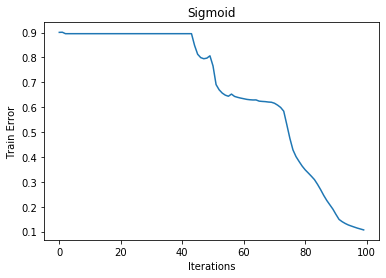

In [28]:
a = Neural_Net(5,[28**2,256,128,64,10],'sigmoid',0.1)
err = a.fit(train_x,train_y)
sc = a.score(test_x,test_y)
print(sc)

plt.plot(np.arange(100),err)
plt.title('Sigmoid')
plt.xlabel('Iterations')
plt.ylabel('Train Error')
plt.show()

In [0]:
dbfile = open('/content/gdrive/My Drive/ML/Assignment3/q1/mySigmoid', 'ab')
pickle.dump(a, dbfile)                      
dbfile.close() 

Epoch: 0 Training accuracy: 0.09511666666666663
Epoch: 1 Training accuracy: 0.10441666666666671
Epoch: 2 Training accuracy: 0.10441666666666671
Epoch: 3 Training accuracy: 0.10441666666666671
Epoch: 4 Training accuracy: 0.10441666666666671
Epoch: 5 Training accuracy: 0.10441666666666671
Epoch: 6 Training accuracy: 0.10441666666666671
Epoch: 7 Training accuracy: 0.10441666666666671
Epoch: 8 Training accuracy: 0.37711666666666666
Epoch: 9 Training accuracy: 0.8315833333333333
Epoch: 10 Training accuracy: 0.9146166666666666
Epoch: 11 Training accuracy: 0.9360166666666667
Epoch: 12 Training accuracy: 0.94995
Epoch: 13 Training accuracy: 0.9555333333333333
Epoch: 14 Training accuracy: 0.9607
Epoch: 15 Training accuracy: 0.9664833333333334
Epoch: 16 Training accuracy: 0.9593666666666667
Epoch: 17 Training accuracy: 0.9651
Epoch: 18 Training accuracy: 0.9706333333333333
Epoch: 19 Training accuracy: 0.9719833333333333
Epoch: 20 Training accuracy: 0.9729
Epoch: 21 Training accuracy: 0.974416666

ValueError: ignored

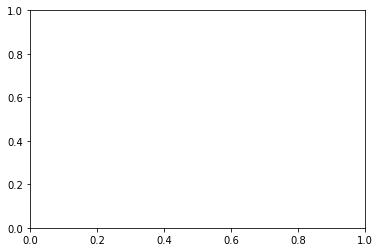

In [21]:
b = Neural_Net(5,[28**2,256,128,64,10],'relu',0.1)
err = b.fit(train_x,train_y,epochs=100)
sc = b.score(test_x,test_y)
print(sc)
dbfile = open('/content/gdrive/My Drive/ML/Assignment3/q1/myRelu', 'ab')
pickle.dump(b, dbfile)                      
dbfile.close() 



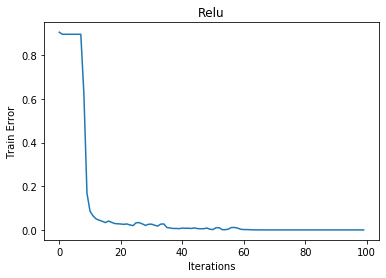

In [23]:
plt.plot(np.arange(100),err)
plt.title('Relu')
plt.xlabel('Iterations')
plt.ylabel('Train Error')
plt.show()

Epoch: 0 Training accuracy: 0.09878333333333333
Epoch: 1 Training accuracy: 0.10441666666666671
Epoch: 2 Training accuracy: 0.10441666666666671
Epoch: 3 Training accuracy: 0.10441666666666671
Epoch: 4 Training accuracy: 0.30935
Epoch: 5 Training accuracy: 0.6206833333333334
Epoch: 6 Training accuracy: 0.74735
Epoch: 7 Training accuracy: 0.8157166666666666
Epoch: 8 Training accuracy: 0.8533666666666667
Epoch: 9 Training accuracy: 0.85535
Epoch: 10 Training accuracy: 0.85665
Epoch: 11 Training accuracy: 0.8574666666666667
Epoch: 12 Training accuracy: 0.8578666666666667
Epoch: 13 Training accuracy: 0.8589833333333333
Epoch: 14 Training accuracy: 0.8779166666666667
Epoch: 15 Training accuracy: 0.8831833333333333
Epoch: 16 Training accuracy: 0.8834
Epoch: 17 Training accuracy: 0.8837333333333334
Epoch: 18 Training accuracy: 0.8838166666666667
Epoch: 19 Training accuracy: 0.8837166666666667
Epoch: 20 Training accuracy: 0.8841166666666667
Epoch: 21 Training accuracy: 0.8846333333333334
Epoch:

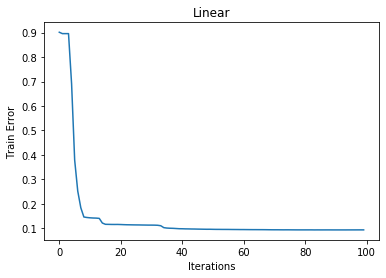

In [25]:
c = Neural_Net(5,[28**2,256,128,64,10],'linear',0.1)
err = c.fit(train_x,train_y,epochs=100)
sc = c.score(test_x,test_y)
print(sc)
dbfile = open('/content/gdrive/My Drive/ML/Assignment3/q1/myLinear', 'ab')
pickle.dump(c, dbfile)                      
dbfile.close()

plt.plot(np.arange(100),err)
plt.title('Linear')
plt.xlabel('Iterations')
plt.ylabel('Train Error')
plt.show()

Epoch: 0 Training accuracy: 0.08245000000000002
Epoch: 1 Training accuracy: 0.10441666666666671
Epoch: 2 Training accuracy: 0.10441666666666671
Epoch: 3 Training accuracy: 0.10441666666666671
Epoch: 4 Training accuracy: 0.2716166666666666
Epoch: 5 Training accuracy: 0.5725166666666667
Epoch: 6 Training accuracy: 0.7680666666666667
Epoch: 7 Training accuracy: 0.8573333333333333
Epoch: 8 Training accuracy: 0.8700166666666667
Epoch: 9 Training accuracy: 0.87835
Epoch: 10 Training accuracy: 0.8931333333333333
Epoch: 11 Training accuracy: 0.8982166666666667
Epoch: 12 Training accuracy: 0.9001166666666667
Epoch: 13 Training accuracy: 0.9026166666666666
Epoch: 14 Training accuracy: 0.90515
Epoch: 15 Training accuracy: 0.9092166666666667
Epoch: 16 Training accuracy: 0.9158833333333334
Epoch: 17 Training accuracy: 0.9214833333333333
Epoch: 18 Training accuracy: 0.9265666666666666
Epoch: 19 Training accuracy: 0.9322
Epoch: 20 Training accuracy: 0.9358166666666666
Epoch: 21 Training accuracy: 0.9

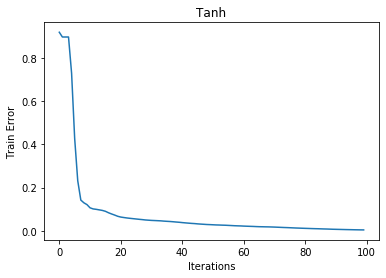

In [27]:
d = Neural_Net(5,[28**2,256,128,64,10],'tanh',0.1)
err = d.fit(train_x,train_y,epochs=100)
sc = d.score(test_x,test_y)
print(sc)
dbfile = open('/content/gdrive/My Drive/ML/Assignment3/q1/myTanh', 'ab')
pickle.dump(d, dbfile)                      
dbfile.close() 

plt.plot(np.arange(100),err)
plt.title('Tanh')
plt.xlabel('Iterations')
plt.ylabel('Train Error')
plt.show()

RELU

In [36]:
reg1 = MLPClassifier(hidden_layer_sizes=(256, 128, 64), solver='sgd',learning_rate='constant', learning_rate_init=0.1, batch_size=128, max_iter=100,verbose=True)
reg1.fit(train_x, train_y)
t = reg1.score(train_x,train_y)
tt = reg1.score(test_x, test_y)
print('Training accuracy:',t)
print('Testing accuracy:',tt)
dbfile = open('/content/gdrive/My Drive/ML/Assignment3/q1/sklearn_relu', 'ab')
pickle.dump(reg1, dbfile)                      
dbfile.close() 

Iteration 1, loss = 0.47844288
Iteration 2, loss = 0.15156598
Iteration 3, loss = 0.10907833
Iteration 4, loss = 0.08467951
Iteration 5, loss = 0.07181850
Iteration 6, loss = 0.05906530
Iteration 7, loss = 0.05155210
Iteration 8, loss = 0.04643946
Iteration 9, loss = 0.04179414
Iteration 10, loss = 0.03655987
Iteration 11, loss = 0.03117815
Iteration 12, loss = 0.02966068
Iteration 13, loss = 0.02553826
Iteration 14, loss = 0.02293330
Iteration 15, loss = 0.02253987
Iteration 16, loss = 0.02088813
Iteration 17, loss = 0.01786116
Iteration 18, loss = 0.01583656
Iteration 19, loss = 0.01677145
Iteration 20, loss = 0.01751674
Iteration 21, loss = 0.01402298
Iteration 22, loss = 0.01406891
Iteration 23, loss = 0.01341955
Iteration 24, loss = 0.01328090
Iteration 25, loss = 0.01196029
Iteration 26, loss = 0.00801536
Iteration 27, loss = 0.00645983
Iteration 28, loss = 0.00512045
Iteration 29, loss = 0.00994121
Iteration 30, loss = 0.00968972
Iteration 31, loss = 0.00568104
Iteration 32, los

Linear

In [37]:
reg2 = MLPClassifier(hidden_layer_sizes=(256, 128, 64), solver='sgd', activation='identity',learning_rate='constant', verbose=True , learning_rate_init=0.1, batch_size=128, max_iter=100)
reg2.fit(train_x, train_y)
t = reg2.score(train_x,train_y)
tt = reg2.score(test_x, test_y)
print('Training accuracy:',t)
print('Testing accuracy:',tt)
dbfile = open('/content/gdrive/My Drive/ML/Assignment3/q1/sklearn_lin', 'ab')
pickle.dump(reg2, dbfile)                      
dbfile.close() 

Iteration 1, loss = 0.44368270
Iteration 2, loss = 0.31369635
Iteration 3, loss = 0.30346944
Iteration 4, loss = 0.29738647
Iteration 5, loss = 0.29167862
Iteration 6, loss = 0.28888978
Iteration 7, loss = 0.28577081
Iteration 8, loss = 0.28418442
Iteration 9, loss = 0.28256424
Iteration 10, loss = 0.28033295
Iteration 11, loss = 0.27986093
Iteration 12, loss = 0.27796524
Iteration 13, loss = 0.27805527
Iteration 14, loss = 0.27641759
Iteration 15, loss = 0.27532951
Iteration 16, loss = 0.27576722
Iteration 17, loss = 0.27344103
Iteration 18, loss = 0.27491846
Iteration 19, loss = 0.27167537
Iteration 20, loss = 0.27225863
Iteration 21, loss = 0.27220610
Iteration 22, loss = 0.27104748
Iteration 23, loss = 0.27000758
Iteration 24, loss = 0.27004663
Iteration 25, loss = 0.27159461
Iteration 26, loss = 0.27051809
Iteration 27, loss = 0.26760979
Iteration 28, loss = 0.26998177
Iteration 29, loss = 0.26800299
Iteration 30, loss = 0.26792068
Iteration 31, loss = 0.26748275
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training accuracy: 0.93005
Testing accuracy: 0.919


Sigmoid

In [41]:
reg3 = MLPClassifier(hidden_layer_sizes=(256, 128, 64), verbose= True ,activation='logistic',learning_rate='constant', learning_rate_init=0.1, batch_size=128, max_iter=100, solver='sgd')
reg3.fit(train_x, train_y)
t = reg3.score(train_x,train_y)
tt = reg3.score(test_x, test_y)
print('Training accuracy:',t)
print('Testing accuracy:',tt)
dbfile = open('/content/gdrive/My Drive/ML/Assignment3/q1/sklearn_logistic', 'ab')
pickle.dump(reg3, dbfile)                      
dbfile.close() 

Iteration 1, loss = 2.30826223
Iteration 2, loss = 2.30363661
Iteration 3, loss = 2.30324459
Iteration 4, loss = 2.30314180
Iteration 5, loss = 2.30314923
Iteration 6, loss = 2.30302231
Iteration 7, loss = 2.30321540
Iteration 8, loss = 2.30303119
Iteration 9, loss = 2.30301509
Iteration 10, loss = 2.30267998
Iteration 11, loss = 2.30278434
Iteration 12, loss = 2.30268902
Iteration 13, loss = 2.30244630
Iteration 14, loss = 2.30195891
Iteration 15, loss = 2.30023156
Iteration 16, loss = 2.22814598
Iteration 17, loss = 1.72253803
Iteration 18, loss = 1.54000104
Iteration 19, loss = 1.48857296
Iteration 20, loss = 1.44241642
Iteration 21, loss = 1.14366334
Iteration 22, loss = 0.94602274
Iteration 23, loss = 0.84055564
Iteration 24, loss = 0.68484890
Iteration 25, loss = 0.57881125
Iteration 26, loss = 0.54036614
Iteration 27, loss = 0.50895201
Iteration 28, loss = 0.46746202
Iteration 29, loss = 0.43492602
Iteration 30, loss = 0.41229156
Iteration 31, loss = 0.38779403
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training accuracy: 0.9760666666666666
Testing accuracy: 0.9648


Tanh

In [39]:
reg4 = MLPClassifier(hidden_layer_sizes=(256, 128, 64), verbose = True, solver='sgd', activation='tanh',learning_rate='constant', learning_rate_init=0.1, batch_size=128, max_iter=100)
reg4.fit(train_x, train_y)
t = reg4.score(train_x,train_y)
tt = reg4.score(test_x, test_y)
print('Training accuracy:',t)
print('Testing accuracy:',tt)


Iteration 1, loss = 0.41597922
Iteration 2, loss = 0.21686119
Iteration 3, loss = 0.17002546
Iteration 4, loss = 0.14301172
Iteration 5, loss = 0.12472952
Iteration 6, loss = 0.11073870
Iteration 7, loss = 0.10183973
Iteration 8, loss = 0.09198013
Iteration 9, loss = 0.08271423
Iteration 10, loss = 0.07501413
Iteration 11, loss = 0.06968924
Iteration 12, loss = 0.06230268
Iteration 13, loss = 0.05731446
Iteration 14, loss = 0.05244455
Iteration 15, loss = 0.05063450
Iteration 16, loss = 0.04443693
Iteration 17, loss = 0.04291616
Iteration 18, loss = 0.03912852
Iteration 19, loss = 0.03448261
Iteration 20, loss = 0.03163394
Iteration 21, loss = 0.03032716
Iteration 22, loss = 0.02732701
Iteration 23, loss = 0.02368234
Iteration 24, loss = 0.02394295
Iteration 25, loss = 0.02086798
Iteration 26, loss = 0.01975023
Iteration 27, loss = 0.01812395
Iteration 28, loss = 0.01631443
Iteration 29, loss = 0.01363775
Iteration 30, loss = 0.01321733
Iteration 31, loss = 0.01149995
Iteration 32, los

In [0]:
dbfile = open('/content/gdrive/My Drive/ML/Assignment3/q1/sklearn_tanh', 'ab')
pickle.dump(reg4, dbfile)                      
dbfile.close() 